<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./




Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

True

## Load Target Series Data

In [230]:
from darts import TimeSeries
import pandas as pd


Load price history
* Then split into target series and past covariates

In [ ]:
stocks_price_file = 'data/all_stocks_price_hist.csv.bz2'

In [265]:
# How far back should the model look in order to make a prediction
train_history = 252*2 # 252 days in a year with market data
# How far into the future should the model forecast
pred_horizon = 21*2 # 21 days in a month with market data


In [266]:

n_test_range_days = train_history+3*pred_horizon
print(f'n_test_range_days: {n_test_range_days}')


# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = n_test_range_days*3
print(f'min_samples: {min_samples}')

n_test_range_days: 630
min_samples: 1890


In [232]:

from canswim import targets

ticker_dict = targets.load_stock_prices(csv_file=stocks_price_file, min_samples=min_samples)



In [233]:
stock_tickers = list(set(ticker_dict.keys()))

len(stock_tickers)


1855

## Config Training Parameters

In [343]:
from dotenv import load_dotenv
import pandas as pd
import os

# load from .env file or OS vars if available
load_dotenv(override=True)

n_stocks = int(os.getenv("n_stocks", 50)) # -1 for all, otherwise a number like 300
print('n_stocks: ', n_stocks)
n_epochs = int(os.getenv("n_epochs", 5)) # model training epochs
print('n_epochs: ', n_epochs)

# pick the earlies date after which market data is available for all covariate series
train_date_start = pd.Timestamp(os.getenv("train_date_start", '1991-01-01'))



n_stocks:  20
n_epochs:  10


### Pick a sample stock subset for the training loop

In [344]:
import random

# reduce ticker set to a workable size for the training loop
stock_tickers = random.sample(stock_tickers, n_stocks)

In [345]:
print(list(stock_tickers))

['AMNB', 'GRBK', 'ORA', 'BFH', 'CINF', 'FI', 'RMAX', 'MELI', 'FVCB', 'AORT', 'OPI', 'WVE', 'UBS', 'NECB', 'DB', 'NIC', 'CPE', 'MGPI', 'TMO', 'VRNS']


In [346]:

from canswim import targets

ticker_train_dict = dict((k, ticker_dict[k]) for k in stock_tickers)
ticker_series = targets.prepare_ticker_series(ticker_dict=ticker_train_dict, train_date_start=train_date_start)


Preparing ticker series for 20 stocks.


Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict created with train start date.
Added holidays to ticker series.
Ticker series prepared.


Prepare multiple series - one per stock ticker

In [347]:
ticker_series

{'AMNB': <TimeSeries (DataArray) (Date: 6465, component: 7, sample: 1)>
 array([[[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
         [5.57931185e+00],
         [1.20000000e+03],
         [0.00000000e+00]],
 
        [[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
         [5.57931185e+00],
         [8.00000000e+02],
         [0.00000000e+00]],
 
        [[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
 ...
         ...,
         [4.59000015e+01],
         [1.24000000e+04],
         [0.00000000e+00]],
 
        [[4.63199997e+01],
         [4.70400009e+01],
         [4.55200005e+01],
         ...,
         [4.70299988e+01],
         [1.57000000e+04],
         [0.00000000e+00]],
 
        [[4.71500015e+01],
         [4.77700005e+01],
         [4.71699982e+01],
         ...,
         [4.77700005e+01],
         [2.50200000e+03],
         [0.00000000e+00]]])
 Coordinates:
 

In [348]:
# prepare target univariate series for Close price
# target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}

# target_columns = ['Open', 'Close']
target_columns = ['Close']

target_series = targets.prepare_target_series(ticker_series=ticker_series, target_columns=target_columns)

Preparing univariate target series: Close


In [349]:
target_series

{'AMNB': <TimeSeries (DataArray) (Date: 6465, component: 1, sample: 1)>
 array([[[14.        ]],
 
        [[14.        ]],
 
        [[14.        ]],
 
        ...,
 
        [[45.90000153]],
 
        [[47.02999878]],
 
        [[47.77000046]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1999-04-13 1999-04-14 ... 2024-01-22
   * component  (component) object 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'GRBK': <TimeSeries (DataArray) (Date: 4329, component: 1, sample: 1)>
 array([[[133.15927124]],
 
        [[133.15927124]],
 
        [[134.4647522 ]],
 
        ...,
 
        [[ 50.68999863]],
 
        [[ 50.88999939]],
 
        [[ 52.27500153]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-06-20 2007-06-21 ... 2024-01-22
   * component  (component) object 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'ORA'

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [350]:
from canswim import covariates

price_covariates = covariates.get_price_covariates(ticker_series=ticker_series, target_columns=target_columns)


In [351]:
price_covariates.keys()

dict_keys(['AMNB', 'GRBK', 'ORA', 'BFH', 'CINF', 'FI', 'RMAX', 'MELI', 'FVCB', 'AORT', 'OPI', 'WVE', 'UBS', 'NECB', 'DB', 'NIC', 'CPE', 'MGPI', 'TMO', 'VRNS'])

AMNB past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
GRBK past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
ORA past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
BFH past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

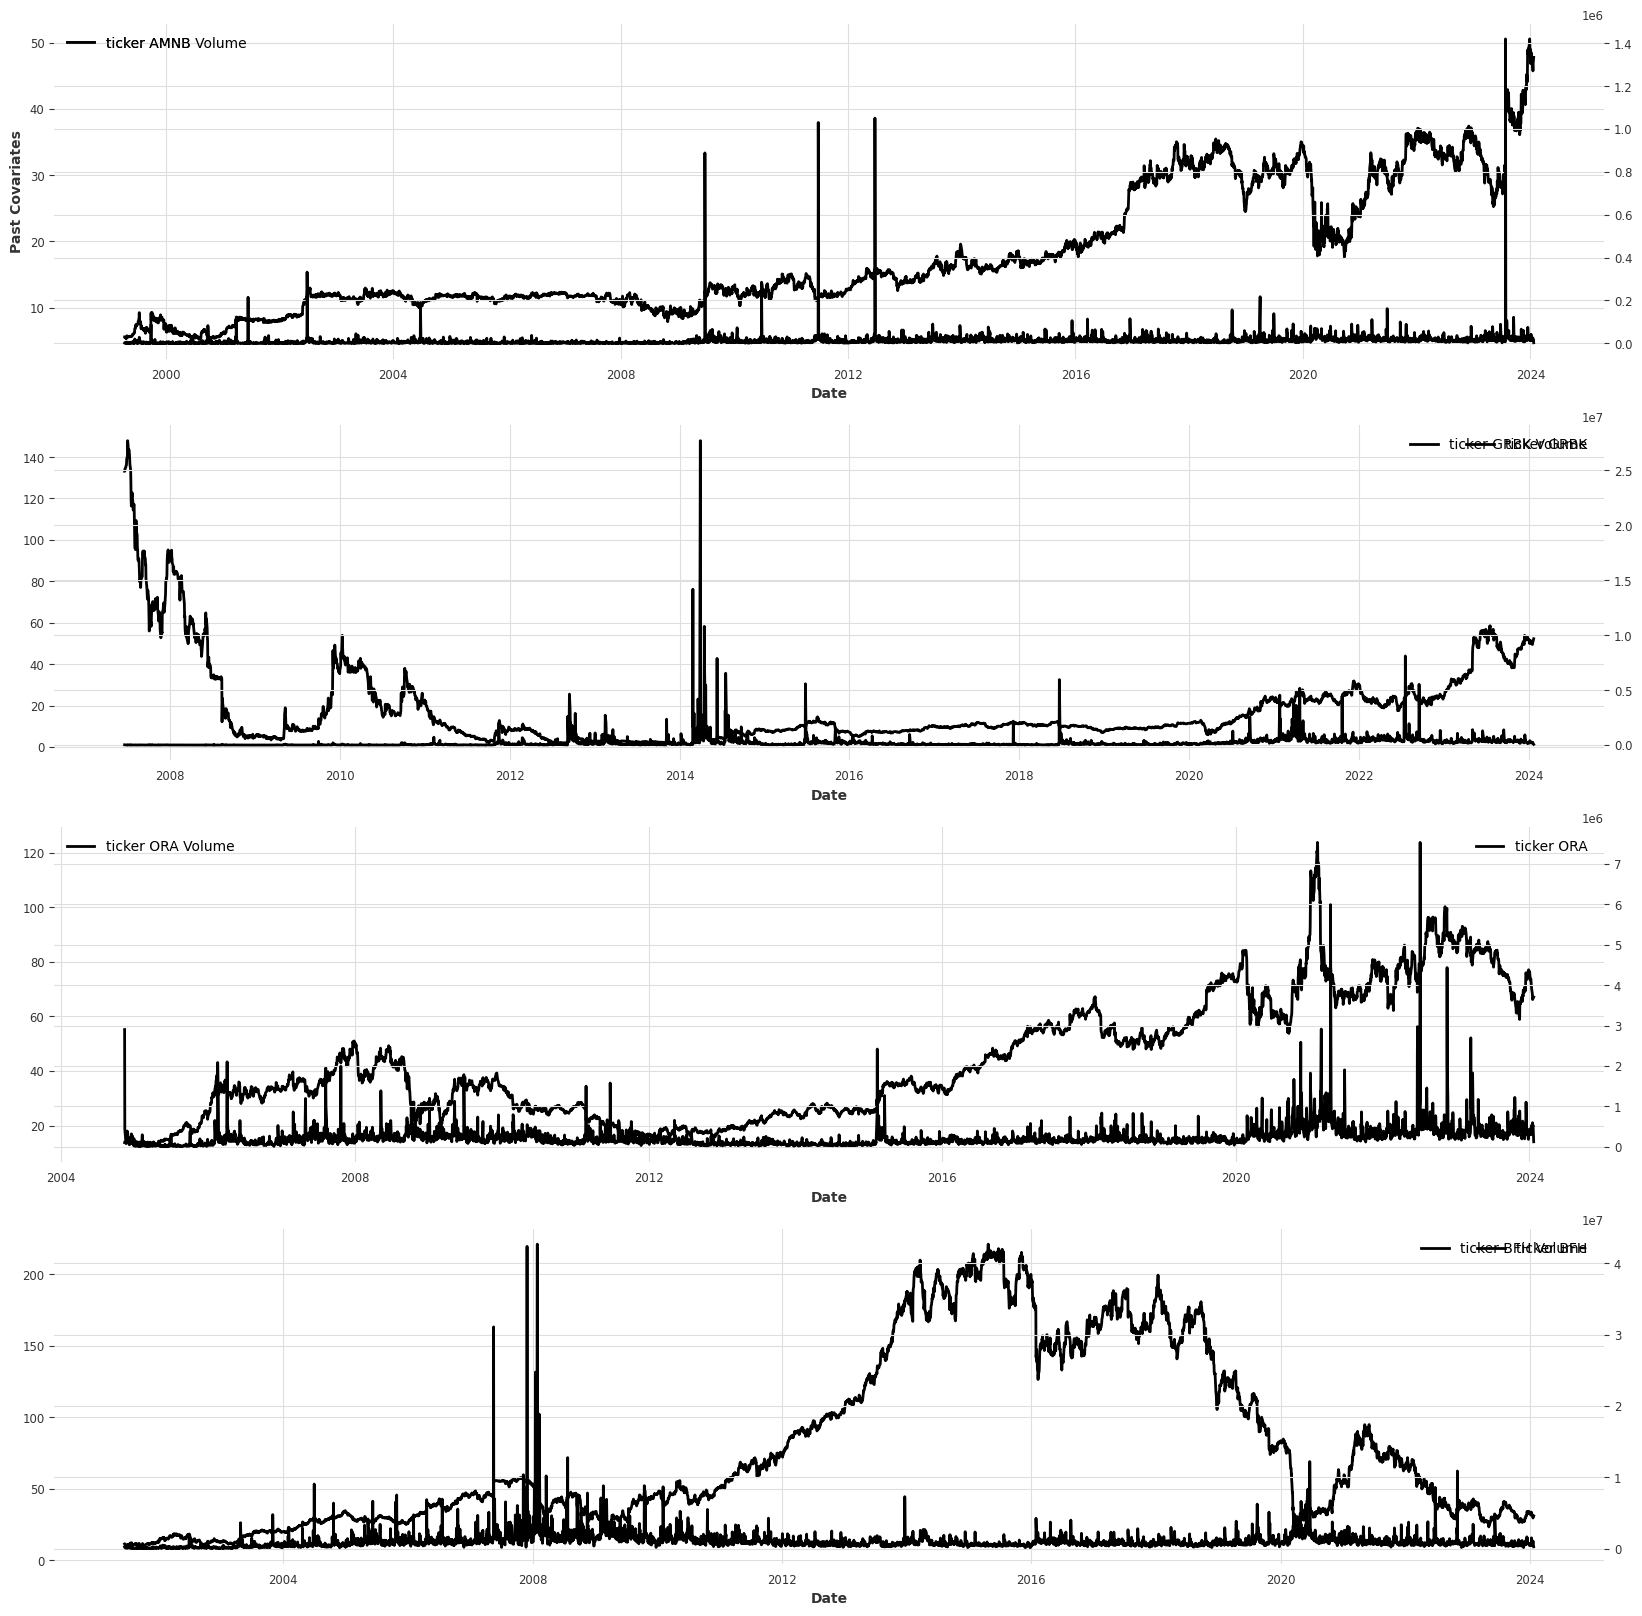

In [352]:
import matplotlib.pyplot as plt


n_plot_samples = 4

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(price_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {price_covariates[t].columns}')
        price_covariates[t].univariate_component('Adj Close').plot(label=f'ticker {t} ', ax=axes[i])
        price_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes2[i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [353]:
from canswim import covariates

earnings_csv_file = 'data/earnings_calendar.csv.bz2'

earn_covariates = covariates.prepare_earn_series(csv_file=earnings_csv_file, tickers=ticker_series.keys())

       symbol        date     eps  epsEstimated time       revenue  \
0          CF  2024-10-31     NaN           NaN  amc           NaN   
1          CF  2024-08-08     NaN           NaN  amc           NaN   
2          CF  2024-05-02     NaN           NaN  amc           NaN   
3          CF  2024-02-14     NaN          1.56  bmo           NaN   
4          CF  2023-11-01  0.8500          0.94  amc  1.273000e+09   
...       ...         ...     ...           ...  ...           ...   
214890    GPI  1998-04-21  0.2000          0.17  bmo  2.539000e+08   
214891    GPI  1998-02-17  0.1500          0.15  bmo  2.132000e+08   
214892    GPI  1997-09-30  0.2422           NaN  bmo  2.387000e+08   
214893    GPI  1997-06-30  0.1900           NaN  bmo  2.252000e+08   
214894    GPI  1997-03-31  0.1800           NaN  bmo  2.252000e+08   

        revenueEstimated updatedFromDate fiscalDateEnding  
0                    NaN      2024-01-22       2024-09-30  
1                    NaN      2024-01-2

In [354]:
earn_covariates[t].start_time(), earn_covariates[t].end_time()

(Timestamp('2001-06-29 00:00:00'), Timestamp('2024-10-28 00:00:00'))

In [355]:
from canswim import covariates

past_covariates = covariates.stack_covariates(old_covs=price_covariates, new_covs=earn_covariates)

In [356]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2014-02-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [357]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component        Open       High        Low  Adj Close      Volume  eps  \
Date                                                                      
2014-02-28  13.000000  15.980000  12.666667  14.666667  22129800.0 -1.0   
2014-03-03  14.700000  16.580000  14.253333  14.396667   3434400.0 -1.0   
2014-03-04  15.286667  15.566667  14.666667  15.000000   1439100.0 -1.0   
2014-03-05  15.000000  16.940001  15.000000  16.416668   1672200.0 -1.0   
2014-03-06  17.166668  18.073334  16.666668  17.696667   1823100.0 -1.0   

component   epsEstimated  time  revenue  revenueEstimated  \
Date                                                        
2014-02-28         -0.14   1.0     -1.0        22732093.0   
2014-03-03         -0.14   1.0     -1.0        22732093.0   
2014-03-04         -0.14   1.0     -1.0        22732093.0   
2014-03-05         -0.14   1.0     -1.0        22732093.0   
2014-03-06         -0.14   1.0     -1.0        22732093.0   

### Add key metrics to past covariates

In [358]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [359]:
from canswim.covariates import prepare_key_metrics
kms_series = prepare_key_metrics(csv_file=kms_file, price_series=target_series)

In [360]:
kms_series

{'AMNB': <TimeSeries (DataArray) (Date: 6465, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 0.00000000e+00],
         [ 1.76852706e-02],
         [ 6.55015115e-02]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 2.39391084e+00],
         ...,
         [ 0.00000000e+00],
         [ 1.76852706e-02],
         [ 6.55015115e-02]],
 
        [[ 2.02300000e+03],
         [ 3.00000000e+00],
         [ 2.39391084e+00],
         ...,
         [ 0.00000000e+00],
         [ 1.76852706e-02],
         [ 6.5

In [361]:
kms_series[t].start_time(), kms_series[t].end_time()

(Timestamp('2014-02-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [362]:
from canswim.covariates import stack_covariates

past_covariates = stack_covariates(old_covs=past_covariates, new_covs=kms_series)

In [363]:
len(past_covariates.keys())

20

In [364]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2014-02-28 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [365]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component        Open       High        Low  Adj Close      Volume  eps  \
Date                                                                      
2014-02-28  13.000000  15.980000  12.666667  14.666667  22129800.0 -1.0   
2014-03-03  14.700000  16.580000  14.253333  14.396667   3434400.0 -1.0   
2014-03-04  15.286667  15.566667  14.666667  15.000000   1439100.0 -1.0   
2014-03-05  15.000000  16.940001  15.000000  16.416668   1672200.0 -1.0   
2014-03-06  17.166668  18.073334  16.666668  17.696667   1823100.0 -1.0   

component   epsEstimated  time  revenue  revenueEstimated  ...  \
Date                                                       ...   
2014-02-28         -0.14   1.0     -1.0        22732093.0  ...   
2014-03-03         -0.14   1.0     -1.0        22732093.0  ...   
2014-03-04         -0.14   1.0     -1.0        22732093.0  ...   
2014-03-05         -0.14   1.0     -1.0        22732093.0  ...   
2014-03-06         -0.14   1.0     -

### Add broad market indicators to past covariates

In [366]:
from canswim.covariates import prepare_broad_market_indicators

broad_market_series = prepare_broad_market_indicators(csv_file='data/broad_market.csv.bz2', train_date_start=train_date_start)


In [367]:
broad_market_series

<TimeSeries (DataArray) (Date: 8625, component: 63, sample: 1)>
array([[[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [3.26450012e+02],
        [3.26450012e+02],
        [1.26280000e+08]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [3.26450012e+02],
        [3.26450012e+02],
        [1.26280000e+08]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
...
        ...,
        [4.78093994e+03],
        [4.78093994e+03],
        [4.01900000e+09]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [4.83981006e+03],
        [4.83981006e+03],
        [4.28720000e+09]],

       [[4.19215234e+03],
        [4.21506982e+03],
        [4.19215234e+03],
        ...,
        [4.85910010e+03],
        [4.85910010e+03],
        [2.13186363e+08]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
  * component  (component) object '^R2ESC_Open' '^R2ESC_High' ... '^SPX_Volume'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [368]:

broad_market_dict = {t: broad_market_series for t in target_series.keys()}
past_covariates_tmp = stack_covariates(old_covs=past_covariates, new_covs=broad_market_dict)

In [369]:
past_covariates_tmp

{'AMNB': <TimeSeries (DataArray) (Date: 6465, component: 138, sample: 1)>
 array([[[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
         [1.34981995e+03],
         [1.34981995e+03],
         [8.10900000e+08]],
 
        [[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
         [1.32843994e+03],
         [1.32843994e+03],
         [9.52000000e+08]],
 
        [[1.40000000e+01],
         [1.40000000e+01],
         [1.40000000e+01],
         ...,
 ...
         ...,
         [4.78093994e+03],
         [4.78093994e+03],
         [4.01900000e+09]],
 
        [[4.63199997e+01],
         [4.70400009e+01],
         [4.55200005e+01],
         ...,
         [4.83981006e+03],
         [4.83981006e+03],
         [4.28720000e+09]],
 
        [[4.71500015e+01],
         [4.77700005e+01],
         [4.71699982e+01],
         ...,
         [4.85910010e+03],
         [4.85910010e+03],
         [2.13186363e+08]]])
 Coordinates:

In [370]:
past_covariates = past_covariates_tmp

## Prepare Future Covariates

### Add holidays as future covariates

In [371]:
from canswim.covariates import prepare_holidays
future_covariates = prepare_holidays(ticker_series)
future_covariates

{'AMNB': <TimeSeries (DataArray) (Date: 6465, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1999-04-13 1999-04-14 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'GRBK': <TimeSeries (DataArray) (Date: 4329, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2007-06-20 2007-06-21 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'ORA': <TimeSeries (DataArray) (Date: 5008, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
       

### Add forward looking analyst estimates to future covariates

#### Load annual analyst estimates

In [372]:
from canswim.covariates import prepare_analyst_estimates

## Prepare quarly and annual analyst estimates as future covariates
quarter_est_series, annual_est_series = prepare_analyst_estimates(csv_file_quarter="data/analyst_estimates_quarter.csv.bz2", csv_file_annual="data/analyst_estimates_annual.csv.bz2")
## Stack analyst estimates to future covariates
stacked_future_covariates = stack_covariates(old_covs=future_covariates, new_covs=quarter_est_series)
stacked_future_covariates = stack_covariates(old_covs=stacked_future_covariates, new_covs=annual_est_series, min_samples=min_samples)


TypeError: 'NoneType' object is not iterable

In [ ]:
# future_covariates = stacked_future_covariates

In [ ]:
future_covariates

{'NECB': <TimeSeries (DataArray) (Date: 4578, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2006-07-06 2006-07-07 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'TMO': <TimeSeries (DataArray) (Date: 8625, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-22
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'RMAX': <TimeSeries (DataArray) (Date: 2689, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
       

## Reconcile data sets

In [ ]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: set(). Keeping {'VRNS', 'NECB', 'NIC', 'AORT', 'UBS', 'WVE', 'MGPI', 'ORA', 'CPE', 'FI', 'DB', 'BFH', 'TMO', 'FVCB', 'MELI', 'RMAX', 'OPI', 'AMNB', 'GRBK', 'CINF'} 


In [ ]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [ ]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [ ]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [ ]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [ ]:
import functools
from pandas.tseries.offsets import BDay


val_start = {}
test_start = {}

for t, target in target_series.items():
    test_start[t] = target.end_time() - BDay(n=n_test_range_days)
    val_start[t] = test_start[t] - BDay(n=n_test_range_days)



### Drop series that do not have sufficient training data

In [ ]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if len(target) >= min_samples:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        # print(f'preparing train, val split for {t}')
        print(f'Removing {t} from training loop. Not enough samples')



In [ ]:
target_series = target_series_ok

In [ ]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

print(f'Preparing train, val, test splits')

for t, target in target_series.items():
    if len(target) > min_samples:
        print(f'preparing train, val split for {t}')
        print(f'{t} test_start: {test_start[t]}')
        print(f'{t} val_start: {val_start[t]}')
        print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
        train, val = target.split_before(val_start[t])
        val, test = val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(train.gaps().index) == 0)
        assert(len(val) >= n_test_range_days), f'val samples {len(val)} but must be at least {n_test_range_days}'
        assert(len(test) >= n_test_range_days), f'test samples {len(test)} but must be at least {n_test_range_days}'
        train_series[t] = train
        val_series[t] = val
        test_series[t] = test
        past_train, past_val = past_covariates[t].split_before(val_start[t])
        past_val, past_test = past_val.split_before(test_start[t])
        # there should be no gaps in the training data
        assert(len(past_train.gaps().index) == 0)
        past_covariates_train[t] = past_train 
        past_covariates_val[t] = past_val
        past_covariates_test[t] = past_test
    else:
        print(f'Removing {t} from train set. Not enough samples. Minimum {min_samples} needed, but only {len(target)} available')



Preparing train, val, test splits
preparing train, val split for VRNS
VRNS test_start: 2021-08-23 00:00:00
VRNS val_start: 2019-03-25 00:00:00
VRNS start time, end time: 2014-02-28 00:00:00, 2024-01-22 00:00:00
preparing train, val split for NECB
NECB test_start: 2021-08-23 00:00:00
NECB val_start: 2019-03-25 00:00:00
NECB start time, end time: 2006-07-06 00:00:00, 2024-01-22 00:00:00
preparing train, val split for NIC
NIC test_start: 2021-08-23 00:00:00
NIC val_start: 2019-03-25 00:00:00
NIC start time, end time: 2013-05-17 00:00:00, 2024-01-22 00:00:00
preparing train, val split for AORT
AORT test_start: 2021-08-23 00:00:00
AORT val_start: 2019-03-25 00:00:00
AORT start time, end time: 1993-02-12 00:00:00, 2024-01-22 00:00:00
preparing train, val split for UBS
UBS test_start: 2021-08-23 00:00:00
UBS val_start: 2019-03-25 00:00:00
UBS start time, end time: 2000-05-16 00:00:00, 2024-01-22 00:00:00
preparing train, val split for WVE
WVE test_start: 2021-08-23 00:00:00
WVE val_start: 201

In [ ]:
len(target)

8625

In [ ]:
train_series, val_series, test_series

({'VRNS': <TimeSeries (DataArray) (Date: 1321, component: 1, sample: 1)>
  array([[[14.66666698]],
  
         [[14.39666653]],
  
         [[15.        ]],
  
         ...,
  
         [[20.59000015]],
  
         [[21.03666687]],
  
         [[20.05333328]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2014-02-28 2014-03-03 ... 2019-03-22
    * component  (component) object 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'NECB': <TimeSeries (DataArray) (Date: 3317, component: 1, sample: 1)>
  array([[[8.20895481]],
  
         [[8.39552212]],
  
         [[8.32089615]],
  
         ...,
  
         [[8.71641827]],
  
         [[8.69402981]],
  
         [[8.66417885]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2006-07-06 2006-07-07 ... 2019-03-22
    * component  (component) object 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hi

In [ ]:
past_covariates_train, past_covariates_val, past_covariates_test

({'VRNS': <TimeSeries (DataArray) (Date: 1321, component: 138, sample: 1)>
  array([[[1.30000000e+01],
          [1.59799995e+01],
          [1.26666670e+01],
          ...,
          [1.85944995e+03],
          [1.85944995e+03],
          [3.91745000e+09]],
  
         [[1.46999998e+01],
          [1.65799999e+01],
          [1.42533331e+01],
          ...,
          [1.84572998e+03],
          [1.84572998e+03],
          [3.42822000e+09]],
  
         [[1.52866669e+01],
          [1.55666666e+01],
          [1.46666670e+01],
          ...,
  ...
          ...,
          [2.82422998e+03],
          [2.82422998e+03],
          [3.77916000e+09]],
  
         [[2.05533333e+01],
          [2.10666676e+01],
          [2.05240002e+01],
          ...,
          [2.85487988e+03],
          [2.85487988e+03],
          [3.61262000e+09]],
  
         [[2.09099998e+01],
          [2.09133339e+01],
          [2.00266666e+01],
          ...,
          [2.80070996e+03],
          [2.80070996e+03],
 

Plot data splits

Text(0, 0.5, 'Target Series')

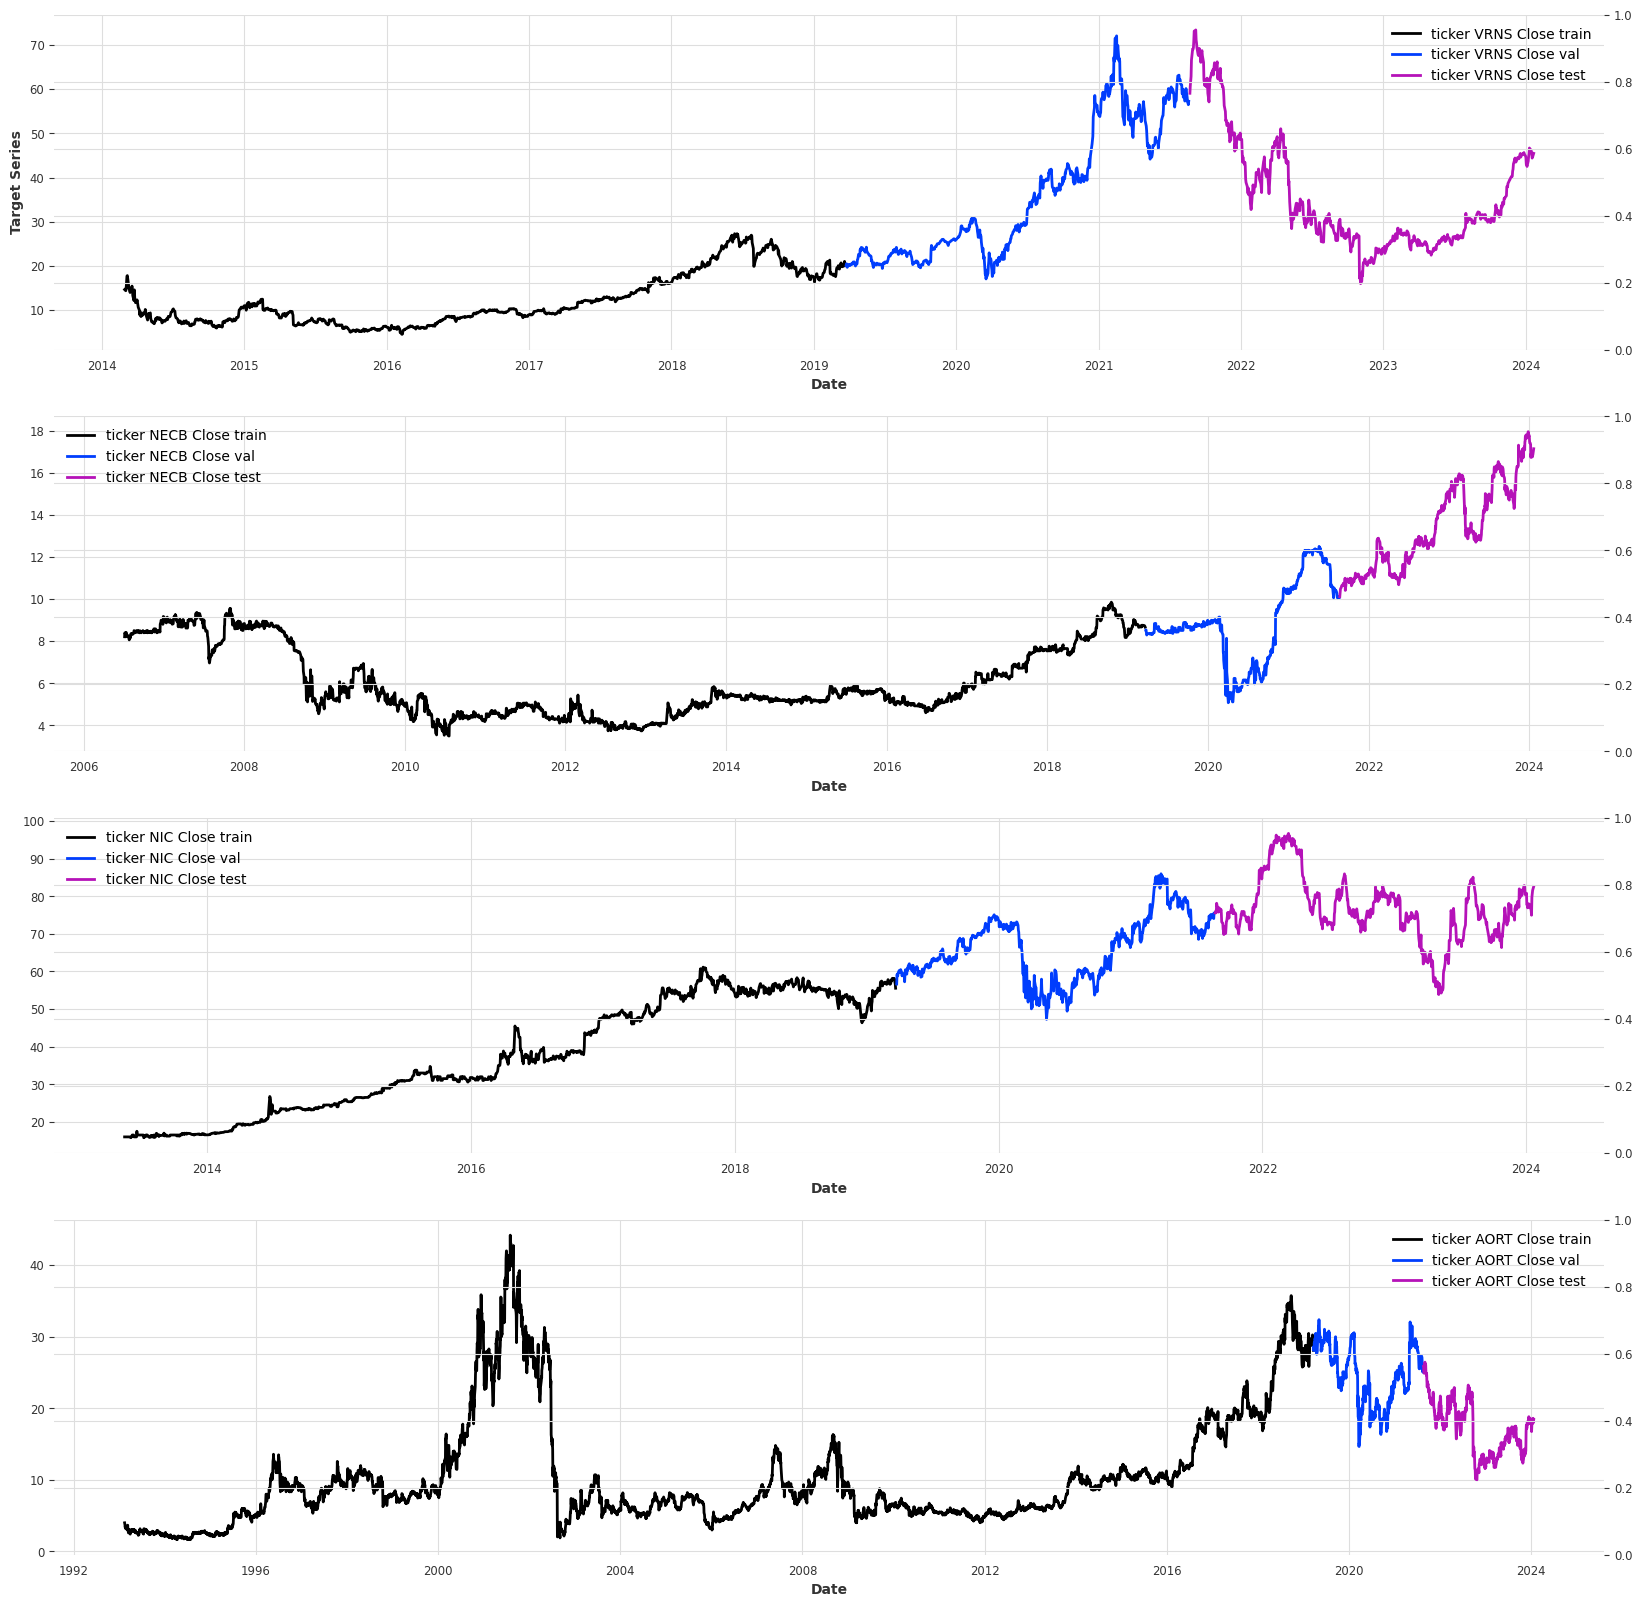

In [ ]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 20))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break

    train_series[t]['Close'].plot(label=f'ticker {t} Close train', ax=axes[i])
#    train_series[t]['Volume'].plot(label=f'ticker {t} Volume train', ax=axes2[i])

    val_series[t]['Close'].plot(label=f'ticker {t} Close val', ax=axes[i])
#    val_series[t]['Volume'].plot(label=f'ticker {t} Volume val', ax=axes2[i])

    test_series[t]['Close'].plot(label=f'ticker {t} Close test', ax=axes[i])
#    test_series[t]['Volume'].plot(label=f'ticker {t} Volume test', ax=axes2[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

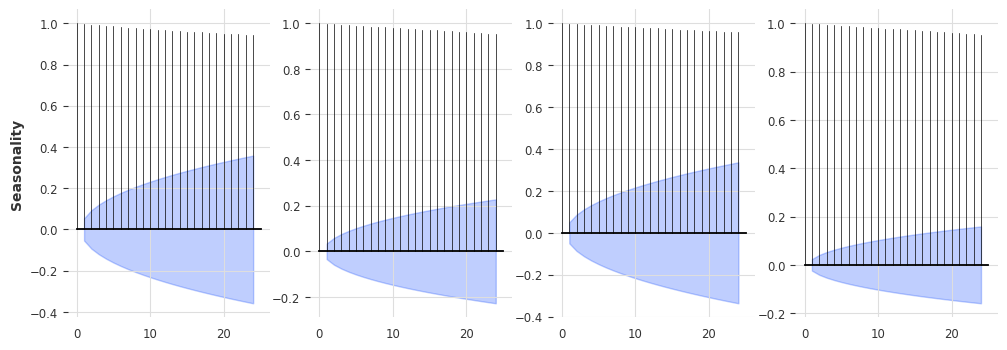

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t]['Close'], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [ ]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [ ]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    # "accelerator": "auto",
    "accelerator": "gpu", 
    "accelerator": "gpu",
    "devices": [0],
    # "auto_select_gpus": True,
    "callbacks": [],
}

# pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256, # 512,
    "random_state": 42,
}

In [ ]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  if torch.cuda.is_available():
    map_location="cuda"
    # utilize CUDA tensor cores with bfloat16
    # https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
    torch.set_float32_matmul_precision('medium') #  | 'high'
  else:
    map_location="cpu"
  model = TiDEModel.load(saved_model_name, map_location=map_location)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  # using TiDE hyperparameters from Table 8 in section B.3 of the original paper
  # https://arxiv.org/pdf/2304.08424.pdf
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=128,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=1
  )
  


Loading saved model


In [ ]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [ ]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


20
20
20
20
20
20
20


In [ ]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [ ]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


5204
5204
630
630
631
631
6465


In [ ]:
target_train_list[0].pd_dataframe()

component       Close
Date                 
1999-04-13  14.000000
1999-04-14  14.000000
1999-04-15  14.000000
1999-04-16  14.000000
1999-04-19  14.000000
...               ...
2019-03-18  35.119999
2019-03-19  35.160000
2019-03-20  34.599998
2019-03-21  34.480000
2019-03-22  32.959999

[5204 rows x 1 columns]

In [ ]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1999-04-13 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
past_cov_list[0].pd_dataframe().columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated',
       ...
       '^NDX_Low', '^NDX_Close', '^NDX_Adj Close', '^NDX_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume'],
      dtype='object', name='component', length=138)

In [ ]:
past_cov_list[0].pd_dataframe()

component        Open       High        Low  Adj Close   Volume  eps  \
Date                                                                   
1999-04-13  14.000000  14.000000  14.000000   5.579312   1200.0 -1.0   
1999-04-14  14.000000  14.000000  14.000000   5.579312    800.0 -1.0   
1999-04-15  14.000000  14.000000  14.000000   5.579312    600.0 -1.0   
1999-04-16  14.000000  14.000000  14.000000   5.579312      0.0 -1.0   
1999-04-19  14.000000  14.000000  14.000000   5.579312      0.0 -1.0   
...               ...        ...        ...        ...      ...  ...   
2019-03-18  34.619999  35.439999  34.619999  29.910690  11200.0 -1.0   
2019-03-19  35.070000  35.459999  34.880001  29.944761   5900.0 -1.0   
2019-03-20  34.919998  35.150002  34.599998  29.467827  11400.0 -1.0   
2019-03-21  34.599998  34.610001  34.320000  29.365620  15000.0 -1.0   
2019-03-22  34.490002  34.639999  32.930000  28.071083  11800.0 -1.0   

component   epsEstimated  time  revenue  revenueEstimated  ...     ^NDX_Low  \
Date                                                       ...                
1999-04-13          0.33   0.0     -1.0      7.616685e+06  ...  2173.229980   
1999-04-14          0.33   0.0     -1.0      7.616685e+06  ...  2103.629883   
1999-04-15          0.33   0.0     -1.0      7.616685e+06  ...  2053.719971   
1999-04-16          0.33   0.0     -1.0      7.616685e+06  ...  2082.000000   
1999-04-19          0.33   0.0     -1.0      7.616685e+06  ...  1962.560059   
...                  ...   ...      ...               ...  ...          ...   
2019-03-18          0.65   0.0     -1.0      1.744543e+07  ...  7293.850098   
2019-03-19          0.65   0.0     -1.0      1.744543e+07  ...  7321.930176   
2019-03-20          0.65   0.0     -1.0      1.744543e+07  ...  7318.419922   
2019-03-21          0.65   0.0     -1.0      1.744543e+07  ...  7356.939941   
2019-03-22          0.65   0.0     -1.0      1.744543e+07  ...  7323.520020   

component    ^NDX_Close  ^NDX_Adj Close   ^NDX_Volume    ^SPX_Open  \
Date                                                                 
1999-04-13  2175.179932     2175.179932  1.341700e+09  1358.640015   
1999-04-14  2103.629883     2103.629883  1.416190e+09  1349.819946   
1999-04-15  2135.810059     2135.810059  1.233960e+09  1328.439941   
1999-04-16  2086.459961     2086.459961  1.027070e+09  1322.859985   
1999-04-19  1967.579956     1967.579956  1.200990e+09  1319.000000   
...                 ...             ...           ...          ...   
2019-03-18  7326.279785     7326.279785  2.302140e+09  2822.610107   
2019-03-19  7349.279785     7349.279785  2.457920e+09  2840.760010   
2019-03-20  7380.750000     7380.750000  2.464230e+09  2831.340088   
2019-03-21  7493.270020     7493.270020  2.502810e+09  2819.719971   
2019-03-22  7326.060059     7326.060059  2.504740e+09  2844.520020   

component     ^SPX_High     ^SPX_Low   ^SPX_Close  ^SPX_Adj Close  \
Date                                                                
1999-04-13  1362.380005  1344.030029  1349.819946     1349.819946   
1999-04-14  1357.239990  1326.410034  1328.439941     1328.439941   
1999-04-15  1332.410034  1308.380005  1322.849976     1322.849976   
1999-04-16  1325.030029  1311.400024  1319.000000     1319.000000   
1999-04-19  1340.099976  1284.479980  1289.479980     1289.479980   
...                 ...          ...          ...             ...   
2019-03-18  2835.409912  2821.989990  2832.939941     2832.939941   
2019-03-19  2852.419922  2823.270020  2832.570068     2832.570068   
2019-03-20  2843.540039  2812.429932  2824.229980     2824.229980   
2019-03-21  2860.310059  2817.379883  2854.879883     2854.879883   
2019-03-22  2846.159912  2800.469971  2800.709961     2800.709961   

component    ^SPX_Volume  
Date                      
1999-04-13  8.109000e+08  
1999-04-14  9.520000e+08  
1999-04-15  1.089800e+09  
1999-04-16  1.002300e+09  
1999-04-19  1.214400e+09  
...                  ...  
2019-03-18

In [ ]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1999-04-13 00:00:00'), Timestamp('2019-03-22 00:00:00'))

In [ ]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2019-03-25 00:00:00'), Timestamp('2021-08-20 00:00:00'))

In [ ]:
target_test_list[0].start_time(), target_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
past_cov_test_list[0].start_time(), past_cov_test_list[0].end_time()

(Timestamp('2021-08-23 00:00:00'), Timestamp('2024-01-22 00:00:00'))

In [ ]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    252.0
dtype: float64

In [ ]:
future_cov_list[0].columns

Index(['holidays'], dtype='object', name='component')

In [ ]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1999-04-13 00:00:00'), Timestamp('2024-01-22 00:00:00'))

### Run model training loop

In [ ]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=4, ) # num_loader_workers recommended at 4*n_GPUs
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 73.8 K
5 | future_cov_projection | _ResidualBlock   | 3.1 K 
6 | encoders              | Sequential       | 5.9 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 31.8 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
16.9 M    Trainable params
0         Non-trainable params
16.9 M    Total params
67.403    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


TiDEModel(num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=128, use_layer_norm=True, dropout=0.2, use_static_covariates=True, optimizer_kwargs={'lr': 0.000224}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'gpu', 'devices': [0], 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, use_reversible_instance_norm=True, n_epochs=5, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt, log_tensorboard=True, nr_epochs_val_period=1)

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
# pred[0]

In [ ]:
# pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [ ]:
import matplotlib.dates as mdates

def get_val_start_list():
    val_start_list = []
    for t, target in sorted(target_series.items()):
        val_start_list.append(val_start[t])
    return val_start_list


def get_test_start_list():
    val_test_list = []
    for t, target in sorted(target_series.items()):
        val_test_list.append(test_start[t])
    return val_test_list


def get_pred_start(start_times=None, offset=None):
    pred_start = {}
    bdays_offset = BDay(n=train_history + offset*pred_horizon)
    for t, start_time in start_times.items():
        pred_start[t] = start_time + bdays_offset
    return pred_start    

def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start[t]-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_cov_list(pred_start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start[t]-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list

def get_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list, num_loader_workers=4)
    return pred

pred_test_outputs = []
# get predictions at several points in time over the validation set
for w in range(3):
    pred_start = get_pred_start(start_times=test_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_test_outputs.append(pred)


pred_val_outputs = []
# get predictions at several points in time over the validation set
for w in range(15):
    pred_start = get_pred_start(start_times=val_start, offset=w)
    pred_list = get_pred_list(pred_start)    
    past_cov_list = get_past_cov_list(pred_start)
    # print(f'pred_list: \n{pred_list}')
    pred = get_pred(pred_list=pred_list, past_cov_list=past_cov_list)
    pred_val_outputs.append(pred)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

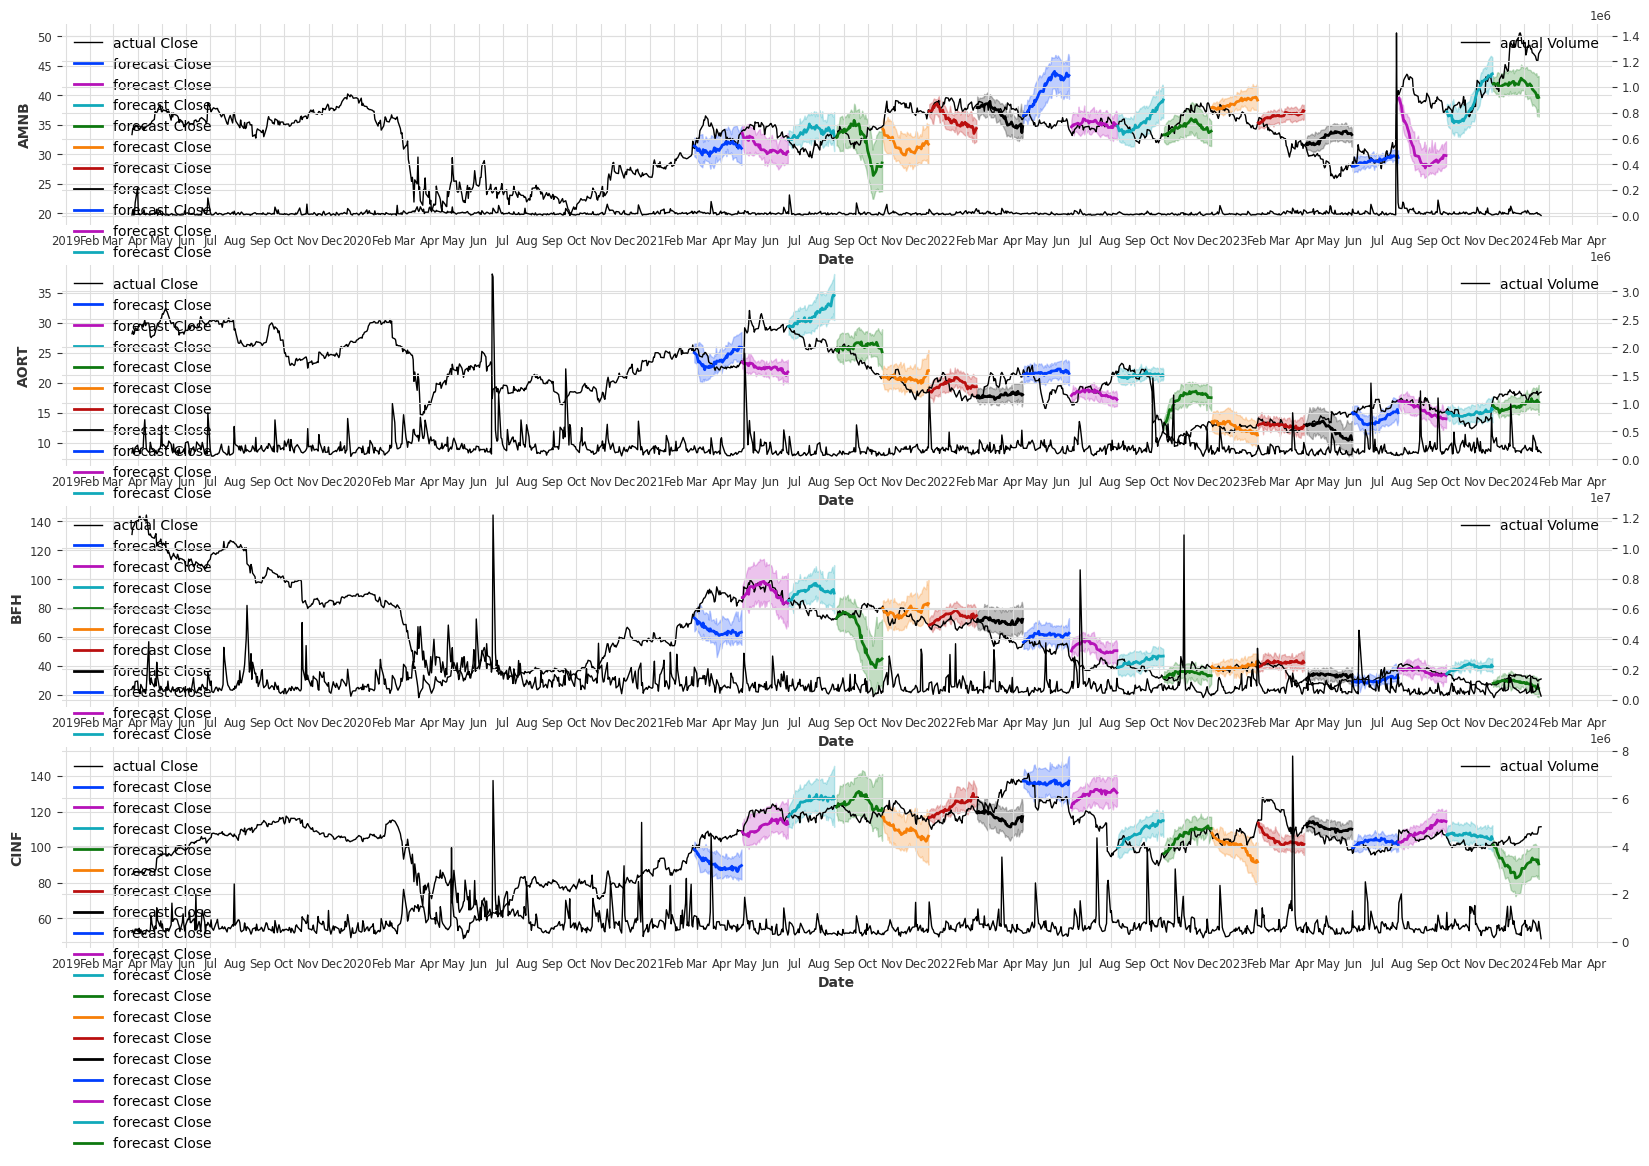

In [ ]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start[t], target.end_time())
            # ax = actual[t]['Open'].plot(label='actual Open', linewidth=1, ax=axes[i])
            ax = actual[t]['Close'].plot(label='actual Close', linewidth=1, ax=axes[i])
            vol = past_covariates[t]['Volume'].slice(val_start[t], target.end_time())
            vol.plot(label='actual Volume', linewidth=1, ax=axes2[i])


def plot_pred(pred_out=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # ax = pred_out[i]['Open'].plot(label=f'forecast Open', linewidth=2, ax=axes[i])
            ax = pred_out[i]['Close'].plot(label=f'forecast Close', linewidth=2, ax=axes[i])
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')



fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(20, 12))
axes2 = {}
for i in range(n_plot_samples):
    axes2[i] = axes[i].twinx()

plot_actual()

# plot predictions at several points in time over the validation set
# plot_pred(pred_outputs=pred_outputs, past_cov_list=past_cov_list)
for pred_out in pred_val_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)

for pred_out in pred_test_outputs:
    plot_pred(pred_out=pred_out, past_cov_list=past_cov_list)


### Backtest Model


In [ ]:
# Backtest model on the full range of test data

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          stride=forecast_horizon,
                                          last_points_only=False,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 4, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
# forecast_start = test_start-BDay(n=30)
pred_start_list = get_test_start_list()
forecast_start = pred_start_list[0]-BDay(n=30)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[0], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[0], future_covariates=future_cov_list[0])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

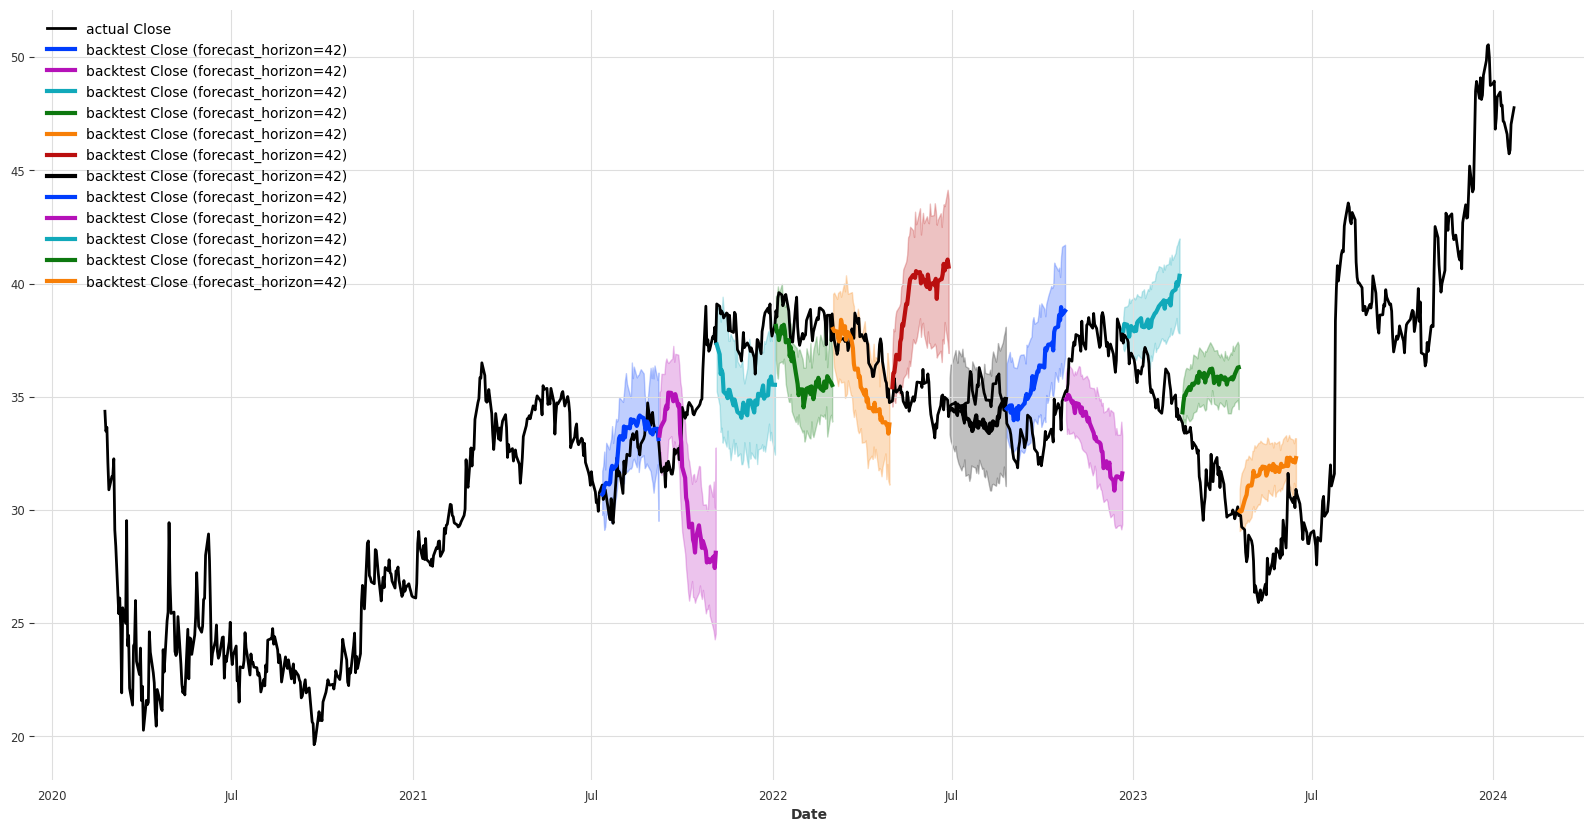

In [ ]:


fig, axes = plt.subplots(figsize=(20, 10))
# axes2 = axes.twinx()

actual_sliced = targets_list[0].slice(forecast_start-pd.Timedelta(days=train_history), target.end_time())
ax = actual_sliced['Close'].plot(label='actual Close', linewidth=2, ax=axes)
# past_cov_list[i]['Volume'].plot(label='actual Volume', ax=axes2)

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13), interval=1))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.grid(True)
ax.set_ylabel(f'{t}')

for i,b in enumerate(backtest):
    # if i < n_plot_samples:
    b.plot(label=f'backtest Close (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes)
    # backtest[i]['Volume'].plot(label=f'backtest Volume (forecast_horizon={forecast_horizon})', linewidth=1, ax=axes2[i])
    plt.legend()




In [ ]:
# use Log RMSE to remove the big variance in absolute price values between difference stocks
from darts.metrics import rmsle


print('Backtest RMSLE = {}'.format(rmsle(targets_list[0], backtest[0])))


Backtest RMSLE = 0.03430477796022025
